## Airline Prices Microchallenge

[Kaggle page](https://www.kaggle.com/alexisbcook/airline-price-optimization-microchallenge)

[DLA Meetup video](https://www.youtube.com/watch?v=irjpteecxdg)

You recently started Aviato.com, a startup that helps airlines set ticket prices. The objective of the startup is to set the ticket prices so that to maximize the total revenue for a given flight.

Inputs:
- Number of days until the flight
- Number of seats available

Objective:
-  Each day, determine optimal ticket prices to **maximize the cumulative revenue**
- optimal prices must be produced by a `pricing_function P(days_left, tickets_left, demand_level)`

Rules:

- The quantity we sell at any price:  `quantity_sold = demand_level - price`
    - linear demand function, see the graph below
- We learn the demand level every day at the time we need to set the ticket price for that day

- Each day, demand level is random, drawn from a uniform distribution ~U[100,200]

- The seats we don't sell today will be available to sell tomorrow, unless the flight leaves that day

- Ticket quantities are capped at the number of seats available


![alt text](https://keydifferences.com/wp-content/uploads/2016/06/shift.jpg)

In [1]:
import numpy as np
import time
from functools import partial

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('ggplot')

In [ ]:
DAYS  = 100    # longest period
SEATS = 100    # max seats

DEMAND_MIN = 100
DEMAND_MAX = 200

In [ ]:
def cumulative_revenue( days_left, 
                        tickets_left, 
                        pricing_function, 
                        rev_to_date = 0,
                        demand_min = DEMAND_MIN,
                        demand_max = DEMAND_MAX,
                       ):
    """ Helper function that calculates the cumulative revenue 
        given a specific pricing function as an argument
        Used to run Monte Carlo simulations of a pricing function
    """
    if days_left>0 and tickets_left>0:   #if there are days left and tickets left
        
        demand = np.random.randint(demand_min, demand_max+1)  # D -- demand level ~U[100,200]  
        p = pricing_function(days_left, tickets_left, demand) # P -- pricing function to optimize
        q = demand - p                 # Q -- tickets sold during the day 
        q = max(0, q)             # Cannot be negative
        q = min(tickets_left, q)  # Cannot sell more than tickets left
       
        return cumulative_revenue(days_left = days_left - 1, 
                                  tickets_left = tickets_left - q, 
                                  pricing_function = pricing_function, 
                                  rev_to_date = rev_to_date + p*q)
    else:
        return rev_to_date

## Heuristics

First, test simple heuristic rules:
- linear pricing function: regardless of the demand level, set the price such that today we sell # seats = total # of seats / # of days
- adaptive pricing function: sell more (or less) seats relative to the linear if the demand today is higher (lower) than the median 150

In [ ]:
def pf_linear(days_left, tickets_left, demand_level):
    """ expect to sell equal # of seats in the remaining days
    """
    price = demand_level - int(tickets_left/days_left)
    return max(0,price)

revenue = cumulative_revenue(DAYS, SEATS,  pf_linear)
print(f'Revenue: {revenue:,}      Avg.price per ticket: {revenue/SEATS:.1f}')

Revenue: 15,033      Avg.price per ticket: 150.3


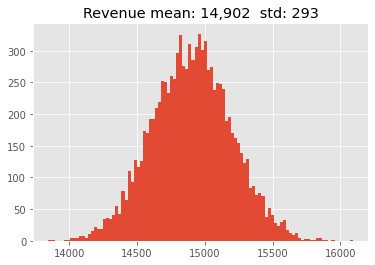

In [ ]:
sim = [cumulative_revenue(DAYS, SEATS, pf_linear) for _ in range(10_000)]
plt.hist(sim, bins=100)
plt.title(f'Revenue mean: {np.mean(sim):,.0f}  std: {np.std(sim):,.0f}');

In [ ]:
def pf_adaptive(days_left, tickets_left, demand_level, adapt=1):
    """ if today's demand is higher than average 150, 
        we can sell more seats by setting the price slightly lower than linear
        parametrized by 'adapt'. adapt=0 is equivalent to linear 
    """
    price = demand_level - int((1 + adapt*(demand_level/150))*tickets_left/days_left)
    return max(0,price)

revenue = cumulative_revenue(DAYS, SEATS,  pf_adaptive)
print(f'Revenue: {revenue:,}      Avg.price per ticket: {revenue/SEATS:.1f}')

Revenue: 15,717      Avg.price per ticket: 157.2


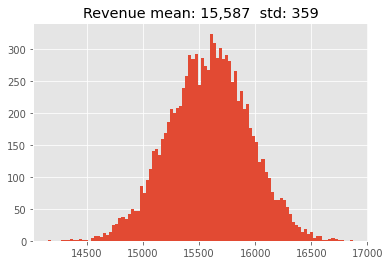

In [ ]:
sim = [cumulative_revenue(DAYS, SEATS, partial(pf_adaptive, adapt=2)) for _ in range(10_000)]
plt.hist(sim, bins=100)
plt.title(f'Revenue mean: {np.mean(sim):,.0f}  std: {np.std(sim):,.0f}');

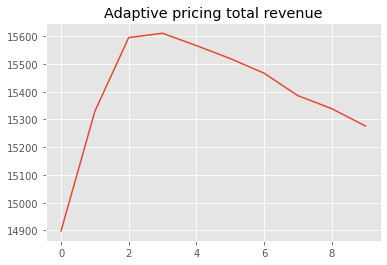

In [ ]:
means = []
for w in range(10):
    sim = [cumulative_revenue(DAYS, SEATS, partial(pf_adaptive, adapt=w)) for _ in range(1_000)]
    means.append(np.mean(sim))
plt.plot(means)
plt.title('Adaptive pricing total revenue');

## Dynamic Programming

Dynamic programming is a method for solving a complex problem by 
- breaking it down into a collection of simpler subproblems (usually sequential steps)
- solving each of those subproblems just once
- and storing their solutions

Examples: Levenshtein distance, knapsack, shortest paths

Why DP? It converts the exponential time of the original problem into **linear time**



![alt text](https://secureservercdn.net/160.153.137.40/662.aa9.myftpupload.com/wp-content/uploads/2020/05/Fib_Recursion.jpg)

In [ ]:
def Fibonacci_recursive(n):
    if   n==1:  return 0
    elif n==2:  return 1
    else:       return Fibonacci_recursive(n-1) + Fibonacci_recursive(n-2)

Fibonacci_recursive(20)

4181

In [ ]:
%%timeit
Fibonacci_recursive(20)

1000 loops, best of 3: 1.66 ms per loop


In [ ]:
memo = [0,1]
 
def Fibonacci_dp(n):
    if n<=len(memo):    return memo[n-1]
    else:
        fib_n = Fibonacci_dp(n-1)+Fibonacci_dp(n-2)
        memo.append(fib_n)
        return fib_n

Fibonacci_dp(20)

4181

In [ ]:
%%timeit
Fibonacci_dp(20)

The slowest run took 16.74 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 162 ns per loop


## Airline Prices DP

Dynamic programming approach: store the expected maximum  revenue for each day and number of seats, working backwards from the last day before the flight.

$P\in[Demand-seats,Demand]$
- lowest price: sell all seats
- highest price: do not sell any seats

$Q = Demand-P$

$CumulativeRevenue(days, seats) = Q*P + E_{Demand}[CumulativeRevenue(days-1, seats-Q)]$

### Last day

What happens at the last day before the flight?

In [ ]:
days_range = list(range(DAYS))                        #   0-99
seats_range = list(range(SEATS+1))                    #   0-100
demand_range = list(range(DEMAND_MIN, DEMAND_MAX+1))  #   100-200

At the last day, there is no expected revenue from the future, only Q*P:

In [ ]:
r_max = np.zeros((len(seats_range), len(demand_range)))
for seats in seats_range:
    for demand in demand_range:
        r_max [seats,demand-DEMAND_MIN]=0
        for p in range(demand-seats, demand+1):   # price can be in the range of [demand-seats:demand] incl
            q = (demand-p)
            r = p*q
            if r>r_max[seats,demand-DEMAND_MIN]:
                r_max [seats,demand-DEMAND_MIN] = r
                

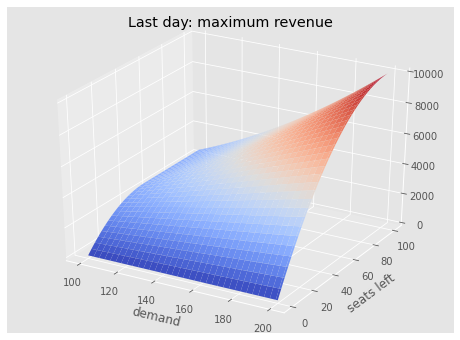

In [ ]:
x, y, z = demand_range,seats_range,r_max
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
x, y = np.meshgrid(x,y)
surface = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
plt.title('Last day: maximum revenue'); plt.xlabel('demand'); plt.ylabel('seats left');

BEFORE we learn the demand for the last day, how much should we expect to sell?

Expectation (taken over possible demand levels) of the maximum revenue in the last day depends only on the number of seats left


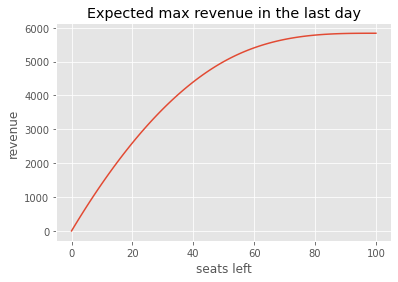

In [ ]:
plt.plot(np.nanmean(r_max, axis=1))
plt.title('Expected max revenue in the last day'); plt.ylabel('revenue'); plt.xlabel('seats left');

### Previous days

Adapted from https://www.kaggle.com/burritodan/airline-price-optimization-micro-challenge

In [ ]:
tic=time.time()

# Kaggle pricing function to be drawn from here:
best_price           = np.zeros((len(days_range)+1, len(seats_range), len(demand_range)))
expected_max_revenue = np.zeros((len(days_range)+1, len(seats_range)))

calc=0

for day in days_range:  #: 0-99. Today is day+1 (i.e. in the range of 1st--100th day)
    for seats in seats_range:

        # for each combination of days left x seats left, calculate the expected maximum revenue
        for demand in demand_range:
            _best_price, _max_revenue = 0,0

            # cycle through all possible prices to find the best price & corresponding maximum revenue
            for price in range(demand-seats, demand+1):
                calc+=1
                q = demand-price
                revenue = price*q + expected_max_revenue[day, seats-q]

                if revenue > _max_revenue: 
                    _best_price, _max_revenue = price, revenue

            # record the found best prices and revenus: the 'dynamic programming' part of the algorithm
            best_price[day+1, seats, demand-DEMAND_MIN] = _best_price
            expected_max_revenue[day+1, seats] += _max_revenue/len(demand_range)  #~Uniform
            
    print(f'\rDay: {day+1}    {time.time()-tic:.1f} sec', end='')

print(f'\ntotal calcs: {calc:,}')

Day: 100    49.7 sec
total calcs: 52,025,100


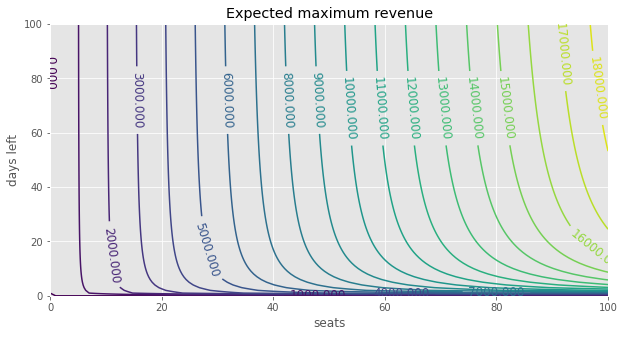

In [ ]:
fig = plt.figure(figsize=(10,5))
CS=plt.contour(days_range+[100], seats_range, expected_max_revenue, levels=20)
plt.clabel(CS, inline=1, fontsize=12)
plt.xlabel('seats'); plt.ylabel('days left'); plt.title('Expected maximum revenue');

### Simulation

Simulating many paths must produce the same revenue (in expectation) as the precomputed expected revenue.
Verify!

In [ ]:
# precomputed and stored:
expected_max_revenue[DAYS, SEATS]

18574.19513177258

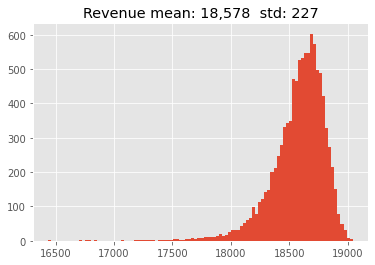

In [ ]:
# simulated over 10_000 runs:
def pf_optimal(days_left, tickets_left, demand_level):
    """ access the precomputed array (DP)
    """
    return best_price[days_left, int(tickets_left), int(demand_level-DEMAND_MIN)]

sim = [cumulative_revenue(DAYS, SEATS, pf_optimal) for _ in range(10_000)]
plt.hist(sim, bins=100)
plt.title(f'Revenue mean: {np.mean(sim):,.0f}  std: {np.std(sim):,.0f}');

In [ ]:
# Kaggle scoring
# Ran 200 flights starting 100 days before flight with 100 tickets. Average revenue: $18456
# Ran 200 flights starting 14 days before flight with 50 tickets. Average revenue: $8534
# Ran 200 flights starting 2 days before flight with 20 tickets. Average revenue: $2873
# Ran 200 flights starting 1 days before flight with 3 tickets. Average revenue: $435
# Average revenue across all flights is $7574

r1 = expected_max_revenue[100, 100]
r2 = expected_max_revenue[14, 50]
r3 = expected_max_revenue[2, 20]
r4 = expected_max_revenue[1, 3]
avg_revenue = np.mean([r1, r2, r3, r4])

print(int(r1))
print(int(r2))
print(int(r3))
print(int(r4))
print(int(avg_revenue))


18574
8492
2905
441
7603
